In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data= pd.read_csv('data_part2.csv')

In [3]:
data.head()

,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding,ENERGYSTARScore,SiteEnergyUse,TotalGHGEmissions,BuildingAge
0,NonResidential,Hotel,DOWNTOWN,1.0,12.0,0,88434,65.0,6981428.0,249.43,88
1,NonResidential,Hotel,DOWNTOWN,1.0,11.0,15064,88502,51.0,8354235.0,263.51,19
2,NonResidential,Hotel,DOWNTOWN,1.0,41.0,0,961990,18.0,73130656.0,2061.48,46
3,NonResidential,Hotel,DOWNTOWN,1.0,10.0,0,61320,1.0,28229320.0,1936.34,89
4,NonResidential,Hotel,DOWNTOWN,1.0,18.0,12460,107430,67.0,14829099.0,507.70,35


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3258 entries, 0 to 3257
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BuildingType         3258 non-null   object 
 1   PrimaryPropertyType  3258 non-null   object 
 2   Neighborhood         3258 non-null   object 
 3   NumberofBuildings    3258 non-null   float64
 4   NumberofFloors       3250 non-null   float64
 5   PropertyGFAParking   3258 non-null   int64  
 6   PropertyGFABuilding  3258 non-null   int64  
 7   ENERGYSTARScore      2174 non-null   float64
 8   SiteEnergyUse        3258 non-null   float64
 9   TotalGHGEmissions    3258 non-null   float64
 10  BuildingAge          3258 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 280.1+ KB


## Preprocessing

### Encodage et standardisation

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

In [7]:
from sklearn.metrics import mean_squared_error, median_absolute_error

In [ ]:
Traitement des variables "TotalGHGEmissions"

#### Traitement des variables "TotalGHGEmissions"

In [8]:
# traitement des variables discrete 
numeric_features = ['PropertyGFAParking','PropertyGFABuilding','BuildingAge']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

# traitement des variables continues : imputation par médiane + log + standardcaler
numeric_log_features = ['NumberofBuildings', 'NumberofFloors','ENERGYSTARScore']
numeric_log_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('log', FunctionTransformer()),
                                          ('scaler', StandardScaler())])

categorical_features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='Other')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])


# couche de preprocessing avec les deux parties ci-dessus appliquées aux données continues et catégorielles
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('num_log', numeric_log_transformer, numeric_log_features),
                                               ('cat', categorical_transformer, categorical_features)])

#Pipeline
pip = Pipeline(steps=[('preprocessor', preprocessor)])

# split "SiteEnergyUse" et "TotalGHGEmissions" into train test sets
X= data.drop(columns=['TotalGHGEmissions','SiteEnergyUse'], axis=1)
y_energy = data['SiteEnergyUse']
y_co2= data['TotalGHGEmissions']

X_train, X_test, y_train_co2, y_test_co2 = train_test_split(X,y_co2, test_size=0.2, random_state=34)


from sklearn import set_config 
set_config(display='diagram')

pip.fit(X_train, y_train_co2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['PropertyGFAParking',
                                                   'PropertyGFABuilding',
                                                   'BuildingAge']),
                                                 ('num_log',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log',
                                                                   FunctionTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'ENERGYSTARScore']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Other',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'Neighborhood'])]))])

In [9]:
# pour s'assurer que ça marche, on voit bien que les données ont été transformées, donc le step du preprocessor marche
pd.DataFrame.sparse.from_spmatrix(pip['preprocessor'].transform(X_test)).sample(5)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
191,-0.310673,-0.417784,0.064910,-0.068398,-0.469835,0.223703,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
483,-0.310673,-0.255098,-0.391279,-0.068398,-0.171240,0.223703,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
578,-0.310673,-0.427163,1.251001,-0.068398,-0.320537,0.223703,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
172,-0.310673,-0.318763,0.186560,-0.068398,-0.469835,0.690996,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
62,-0.310673,-0.414034,0.004085,-0.068398,-0.320537,0.223703,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [10]:
#RandomForestRegressor
model_RFR_co2 = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model_RFR_co2',TransformedTargetRegressor(regressor= RandomForestRegressor()))])
model_RFR_co2.fit(X_train, y_train_co2)
model_RFR_co2.score(X_test, y_test_co2)

0.9213804778826088

In [11]:
#ElasticNet
model_ELN_co2= Pipeline(steps=[('preprocessor', preprocessor),
                              ('ElasticNet',ElasticNet(max_iter=1000))])
model_ELN_co2.fit(X_train, y_train_co2)
model_ELN_co2.score(X_test, y_test_co2)

0.25187674783527136

In [12]:
#svr
model_svr_co2= Pipeline(steps=[('preprocessor', preprocessor),('svr', SVR(kernel='rbf', gamma= 'auto', C= 50000))])
model_svr_co2.fit(X_train, y_train_co2)
model_svr_co2.score(X_test, y_test_co2)

0.8670053491793807

In [13]:
#GradientBoostingRegressor
model_gbr_co2= Pipeline(steps=[('preprocessor', preprocessor),('gbr', GradientBoostingRegressor())])
model_gbr_co2.fit(X_train, y_train_co2)
model_gbr_co2.score(X_test, y_test_co2)

0.8901209926727505

In [14]:
from sklearn.ensemble import ExtraTreesRegressor
# ExtraTreesRegressor
model_etr_co2= Pipeline(steps=[('preprocessor', preprocessor),('etr', ExtraTreesRegressor())])
model_etr_co2.fit(X_train, y_train_co2)
model_etr_co2.score(X_test, y_test_co2)

0.937741475155538

Nous allons continuer avec les modèles "ExtraTreesRegressor" & "GradientBoostingRegressor"& "RandomForestRegressor" & "SVR" qui nous ont donné le meilleur résultat.

### GridSearch

In [15]:
""" RIM RIM RIM"""

# traitement des variables continues : imputation par médiane + log + standardcaler
numeric_log_features = ['NumberofBuildings', 'NumberofFloors','ENERGYSTARScore']
numeric_log_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                          ('log', FunctionTransformer()),
                                          ('scaler', StandardScaler())])

numeric_features = ['PropertyGFAParking','PropertyGFABuilding','BuildingAge']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                      ('scaler', StandardScaler())])

# traitement des variables catégorielles : imputation par "Other" + onehotencoder
categorical_features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='Other')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# couche de preprocessing avec les deux parties ci-dessus appliquées aux données continues et catégorielles
preprocessor = ColumnTransformer(transformers=[('num_log', numeric_log_transformer, numeric_log_features),
                                               ('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features)])

# Jeu brut après nettoyage avec "ENERGYSTARScore" pour évaluer son intérêt pour la prédiction d’émissions
X = data.drop(['TotalGHGEmissions','SiteEnergyUse'], axis=1)
y = data["TotalGHGEmissions"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=27)


In [ ]:
# GradientBoostingRegressor
pipe_gbr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', TransformedTargetRegressor(GradientBoostingRegressor())),
                                         ])
   
grid_gbr = [{'preprocessor__num_log__log__func':[None,np.log1p],
             'model__func':[np.log],
             'model__inverse_func':[np.exp],
             'model__regressor__n_estimators':np.linspace(1200,1800,3).astype(int),
             'model__regressor__learning_rate':[0.16,0.18,0.2],
             'model__regressor__max_depth':[4],
             'model__regressor__subsample':[0.7,0.8,0.9],
             'model__regressor__random_state':[1]},
            {'preprocessor__num_log__log__func':[None,np.log1p],
             'model__func':[None],
             'model__inverse_func':[None],
             'model__regressor__n_estimators':np.linspace(1200,1800,3).astype(int),
             'model__regressor__learning_rate':[0.16,0.18,0.2],
             'model__regressor__max_depth':[4],
             'model__regressor__subsample':[0.7,0.8,0.9],
             'model__regressor__random_state':[1]}
            ]

gs_gbr = GridSearchCV(estimator=pipe_gbr,
                      param_grid=grid_gbr,
                      cv=5,
                      verbose=5)

gs_gbr.fit(X_train, y_train_co2)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\azade\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412,

[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__

C:\Users\azade\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412,

[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__in

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

C:\Users\azade\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412,

[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=

C:\Users\azade\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412,

[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__in

C:\Users\azade\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412,

[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__in

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/5] END model__func=<ufunc 'log'>, model__in

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=

C:\Users\azade\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412,

[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__in

C:\Users\azade\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412,

[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__in

C:\Users\azade\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412,

[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/5] END model__func=<ufunc 'log'>, model__in

C:\Users\azade\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412,

[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=

C:\Users\azade\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412,

[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp

C:\Users\azade\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412,

[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__in

C:\Users\azade\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412,

[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<uf

C:\Users\azade\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412,

[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>,

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__reg

C:\Users\azade\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412,

[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>,

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<uf

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__inver

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<uf

C:\Users\azade\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412,

[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>,

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__reg

C:\Users\azade\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))
C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412,

[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>,

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\compose\_target.py", line 207, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 412, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "C:\Users\azade\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = chec

[CV 4/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 5/5] END model__func=<ufunc 'log'>, model__inverse_func=<ufunc 'exp'>, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   0.0s
[CV 1/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.7, preprocessor__num_log__log__func=None; total time=   3.7s
[CV 2/5] END model__func=None, model__inverse_func=None, model__regressor__learn

[CV 2/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   4.2s
[CV 3/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   3.9s
[CV 4/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   4.2s
[CV 5/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__r

[CV 5/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   5.1s
[CV 1/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   5.1s
[CV 2/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   5.1s
[CV 3/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__m

[CV 3/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   5.9s
[CV 4/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   6.3s
[CV 5/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   5.8s
[CV 1/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.16, model__regressor__max_depth=4, model__reg

[CV 1/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   4.0s
[CV 2/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   4.5s
[CV 3/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   4.2s
[CV 4/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__reg

[CV 4/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   5.9s
[CV 5/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   5.2s
[CV 1/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.9, preprocessor__num_log__log__func=None; total time=   5.1s
[CV 2/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__m

[CV 2/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   6.2s
[CV 3/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   6.2s
[CV 4/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1800, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   6.1s
[CV 5/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__r

[CV 5/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   4.4s
[CV 1/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   4.3s
[CV 2/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=<ufunc 'log1p'>; total time=   4.1s
[CV 3/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_d

[CV 3/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   4.8s
[CV 4/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   4.9s
[CV 5/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regressor__n_estimators=1500, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   5.0s
[CV 1/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.2, model__regressor__max_depth=4, model__regress

In [49]:
gs_gbr.best_params_


{'model__func': None,
 'model__inverse_func': None,
 'model__regressor__learning_rate': 0.18,
 'model__regressor__max_depth': 4,
 'model__regressor__n_estimators': 1200,
 'model__regressor__random_state': 1,
 'model__regressor__subsample': 0.8,
 'preprocessor__num_log__log__func': <ufunc 'log1p'>}

In [131]:
pipe_gbr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', TransformedTargetRegressor(GradientBoostingRegressor()))])
   
grid_gbr_best = [{'preprocessor__num_log__log__func':[None],
                 'model__func': [None],
                 'model__inverse_func': [None],
                 'model__regressor__learning_rate': [0.18],
                 'model__regressor__max_depth': [4],
                 'model__regressor__n_estimators': [1200],
                 'model__regressor__random_state': [1],
                 'model__regressor__subsample': [0.8]} ]

gs_gbr_best = GridSearchCV(estimator=pipe_gbr,
                      param_grid=grid_gbr,
                      cv=5,
                      verbose=5)

GBR_co2= gs_gbr_best.fit(X_train, y_train_co2)
GBR_co2_Score = GBR_co2.score(X_test, y_test_co2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   4.3s
[CV 2/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   3.9s
[CV 3/5] END model__func=None, model__inverse_func=None, model__regressor__learning_rate=0.18, model__regressor__max_depth=4, model__regressor__n_estimators=1200, model__regressor__random_state=1, model__regressor__subsample=0.8, preprocessor__num_log__log__func=None; total time=   3.8s
[CV 4/5] END model__func=None, model__inverse_func=None, model__regressor__le

In [125]:
GBR_co2_Score

0.9143846716911679

In [90]:
print("score d'entrainement = ",gs_gbr.score(X_test, y_test_co2),"\n")
y_pred_co2 = gs_gbr.predict(X_test)
MAE_gbr= mean_absolute_error(y_test_co2,y_pred_co2)
RMSE_gbr = np.sqrt(mean_squared_error(y_test_co2,y_pred_co2))
mae_gbr = median_absolute_error(y_test_co2,y_pred_co2)

print("score de la prédiction:")#, accuracy_score(y_test, y_pred)), 
print("MAE = ",MAE_gbr)
print("RMSE = ",RMSE_gbr)
print("median abs err = ",mae_gbr)

score d'entrainement =  0.9143846716911679 

score de la prédiction:
MAE =  58.778890164895245
RMSE =  186.27225121226425
median abs err =  16.12091206363186


In [148]:
dd={'models': ['Gradient Boosting'],
    'mean_absolute_error': [MAE_gbr],
    'mean_squared_error': [RMSE_gbr]}
df= pd.DataFrame(dd)

In [149]:
df

,models,mean_absolute_error,mean_squared_error
0,Gradient Boosting,58.77889,186.272251


In [150]:
# Temp d'entrainement du modèle
gs_gbr.cv_results_['mean_fit_time'][best_model_index]

3.9510615825653077

In [151]:
gs_gbr.cv_results_['std_fit_time'][best_model_index]

0.12807331159043245

In [161]:
# RandomForestRegressor
pipe_RFR = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', TransformedTargetRegressor(RandomForestRegressor())),
                                         ])
   
grid_RFR = [{
            'preprocessor__num_log__log__func':[None],
            
            "model__regressor__n_estimators": [1,10,20,50,75,200],
            "model__regressor__min_samples_leaf": range(1,10)}
            ]

GS_RFR = GridSearchCV(pipe_RFR,grid_RFR, cv=5, verbose=5)

GS_RFR.fit(X_train, y_train_co2)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END model__regressor__min_samples_leaf=1, model__regressor__n_estimators=1, preprocessor__num_log__log__func=None; total time=   1.1s
[CV 2/5] END model__regressor__min_samples_leaf=1, model__regressor__n_estimators=1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/5] END model__regressor__min_samples_leaf=1, model__regressor__n_estimators=1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/5] END model__regressor__min_samples_leaf=1, model__regressor__n_estimators=1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 5/5] END model__regressor__min_samples_leaf=1, model__regressor__n_estimators=1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 1/5] END model__regressor__min_samples_leaf=1, model__regressor__n_estimators=10, preprocessor__num_log__log__func=None; total time=   0.4s
[CV 2/5] END model__regressor__min_samples_leaf=1, model__regressor__n_estimato

[CV 3/5] END model__regressor__min_samples_leaf=2, model__regressor__n_estimators=200, preprocessor__num_log__log__func=None; total time=   5.4s
[CV 4/5] END model__regressor__min_samples_leaf=2, model__regressor__n_estimators=200, preprocessor__num_log__log__func=None; total time=   5.5s
[CV 5/5] END model__regressor__min_samples_leaf=2, model__regressor__n_estimators=200, preprocessor__num_log__log__func=None; total time=   5.4s
[CV 1/5] END model__regressor__min_samples_leaf=3, model__regressor__n_estimators=1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 2/5] END model__regressor__min_samples_leaf=3, model__regressor__n_estimators=1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 3/5] END model__regressor__min_samples_leaf=3, model__regressor__n_estimators=1, preprocessor__num_log__log__func=None; total time=   0.0s
[CV 4/5] END model__regressor__min_samples_leaf=3, model__regressor__n_estimators=1, preprocessor__num_log__log__func=None; total time= 

[CV 5/5] END model__regressor__min_samples_leaf=4, model__regressor__n_estimators=75, preprocessor__num_log__log__func=None; total time=   1.4s
[CV 1/5] END model__regressor__min_samples_leaf=4, model__regressor__n_estimators=200, preprocessor__num_log__log__func=None; total time=   4.2s
[CV 2/5] END model__regressor__min_samples_leaf=4, model__regressor__n_estimators=200, preprocessor__num_log__log__func=None; total time=   4.2s
[CV 3/5] END model__regressor__min_samples_leaf=4, model__regressor__n_estimators=200, preprocessor__num_log__log__func=None; total time=   4.1s
[CV 4/5] END model__regressor__min_samples_leaf=4, model__regressor__n_estimators=200, preprocessor__num_log__log__func=None; total time=   4.1s
[CV 5/5] END model__regressor__min_samples_leaf=4, model__regressor__n_estimators=200, preprocessor__num_log__log__func=None; total time=   4.2s
[CV 1/5] END model__regressor__min_samples_leaf=5, model__regressor__n_estimators=1, preprocessor__num_log__log__func=None; total t

[CV 2/5] END model__regressor__min_samples_leaf=6, model__regressor__n_estimators=75, preprocessor__num_log__log__func=None; total time=   1.3s
[CV 3/5] END model__regressor__min_samples_leaf=6, model__regressor__n_estimators=75, preprocessor__num_log__log__func=None; total time=   1.3s
[CV 4/5] END model__regressor__min_samples_leaf=6, model__regressor__n_estimators=75, preprocessor__num_log__log__func=None; total time=   1.3s
[CV 5/5] END model__regressor__min_samples_leaf=6, model__regressor__n_estimators=75, preprocessor__num_log__log__func=None; total time=   1.2s
[CV 1/5] END model__regressor__min_samples_leaf=6, model__regressor__n_estimators=200, preprocessor__num_log__log__func=None; total time=   3.6s
[CV 2/5] END model__regressor__min_samples_leaf=6, model__regressor__n_estimators=200, preprocessor__num_log__log__func=None; total time=   3.6s
[CV 3/5] END model__regressor__min_samples_leaf=6, model__regressor__n_estimators=200, preprocessor__num_log__log__func=None; total ti

[CV 4/5] END model__regressor__min_samples_leaf=8, model__regressor__n_estimators=50, preprocessor__num_log__log__func=None; total time=   0.7s
[CV 5/5] END model__regressor__min_samples_leaf=8, model__regressor__n_estimators=50, preprocessor__num_log__log__func=None; total time=   0.7s
[CV 1/5] END model__regressor__min_samples_leaf=8, model__regressor__n_estimators=75, preprocessor__num_log__log__func=None; total time=   1.2s
[CV 2/5] END model__regressor__min_samples_leaf=8, model__regressor__n_estimators=75, preprocessor__num_log__log__func=None; total time=   1.1s
[CV 3/5] END model__regressor__min_samples_leaf=8, model__regressor__n_estimators=75, preprocessor__num_log__log__func=None; total time=   1.1s
[CV 4/5] END model__regressor__min_samples_leaf=8, model__regressor__n_estimators=75, preprocessor__num_log__log__func=None; total time=   1.1s
[CV 5/5] END model__regressor__min_samples_leaf=8, model__regressor__n_estimators=75, preprocessor__num_log__log__func=None; total time=

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['PropertyGFAParking',
                                                                          'PropertyGFABuilding',
                                                                          'BuildingAge']),
                                                                        ('num_log',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log',
                                                                                          FunctionTransformer()...
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['BuildingType',
                                                                          'PrimaryPropertyType',
                                                                          'Neighborhood'])])),
                                       ('model',
                                        TransformedTargetRegressor(regressor=RandomForestRegressor()))]),
             param_grid=[{'model__regressor__min_samples_leaf': range(1, 10),
                          'model__regressor__n_estimators': [1, 10, 20, 50, 75,
                                                             200],
                          'preprocessor__num_log__log__func': [None]}],
             verbose=5)

In [162]:
GS_RFR.best_params_

{'model__regressor__min_samples_leaf': 1,
 'model__regressor__n_estimators': 200,
 'preprocessor__num_log__log__func': None}

In [97]:
# Meilleur score
best_score = float('inf')
# Dictionnaire des modèles hyperparamétrés
rmse_mean, rmse_std = {}, {}
fit_time_mean, fit_time_std = {}, {}

In [98]:
fit_time_mean.keys()

dict_keys([])

In [99]:
  best_model_index = gs_gbr.best_index_

In [100]:
 # Temp d'entrainement du modèle
fit_time_mean[name_reg] = gs_gbr.cv_results_['mean_fit_time'][best_model_index]
fit_time_std[name_reg] = gs_gbr.cv_results_['std_fit_time'][best_model_index]

NameError: name 'name_reg' is not defined

In [126]:
from sklearn.svm import LinearSVR

param_svr = {'regressor__C' : np.logspace(-4, 0, 5),
             'regressor__epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
             'regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
             'regressor__max_iter': [10, 100, 1000]}

svr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_svr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=LinearSVR(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_svr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [128]:
GHG_svr_model = svr_grid_cv.fit(X_train, y_train_co2)
GHG_svr_results = model_scores(GHG_svr_model, 'grid_search_svr')

C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\azade\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more o

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [118]:

# Modèles à hyper-paramétriser
regressors_2 = {
                'Gradient Boosting': GradientBoostingRegressor(random_state=42),
                'Random Forest': RandomForestRegressor(random_state=42),
                'Extra Forest': ExtraTreesRegressor(random_state=42)   
}

In [119]:
# Hyperparamères pour les modèles ensemblistes d'arbres de regression
param_grid_reg_tree = {
    'preprocess__num__imputer__strategy': ['mean', 'median'],# Méthode d'imputation des variables numériques
    'preprocess__cat__imputer__strategy': ['mean', 'median', 'most_frequent'], # Méthode d'imputation des variables catégorielles
    'regressor__n_estimators': [100], # Nombre d'arbres
    'regressor__max_depth': range(2, 20, 2), # Nombre de profondeurs maximums
    'regressor__max_features': range(2, 20, 2) # Nombre de maximum de features
}

# Ajout du paramètre learning rate pour le Gradient Boosting
param_grid_gb = param_grid_reg_tree.copy()
param_grid_gb["regressor__learning_rate"] = [0.01, 0.05, 0.1]
param_grid_gb["regressor__n_estimators"] = [50, 100, 300]

# Dictionnaire de grille de paramètres
param_grid = {'Gradient Boosting': param_grid_gb,
              'Random Forest': param_grid_reg_tree,
              'Extra Forest': param_grid_reg_tree,
             }

In [120]:
# Selection du meilleur modèle
rnd_search_results = rnd_search(regressors_2, 
                                               preprocessor,
                                               param_grid,
                                               X_train,
                                               y_train_co2)

Gradient Boosting


TypeError: 'ColumnTransformer' object is not callable

In [152]:

pipe_gbr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', TransformedTargetRegressor(ExtraTreesRegressor())) ])
   
grid_gbr = [{'preprocessor__num_log__log__func':[None,np.log1p],
             'model__func':[np.log],
             'model__inverse_func':[np.exp],
             'model__regressor__n_estimators':np.linspace(1200,1800,3).astype(int),
             'model__regressor__learning_rate':[0.16,0.18,0.2],
             'model__regressor__max_depth':[4],
             'model__regressor__subsample':[0.7,0.8,0.9],
             'model__regressor__random_state':[1]},
            {'preprocessor__num_log__log__func':[None,np.log1p],
             'model__func':[None],
             'model__inverse_func':[None],
             'model__regressor__n_estimators':np.linspace(1200,1800,3).astype(int),
             'model__regressor__learning_rate':[0.16,0.18,0.2],
             'model__regressor__max_depth':[4],
             'model__regressor__subsample':[0.7,0.8,0.9],
             'model__regressor__random_state':[1]}
            ]

gs_gbr = GridSearchCV(estimator=pipe_gbr,
                      param_grid=grid_gbr,
                      cv=5,
                      verbose=5)

gs_gbr.fit(X_train, y_train_co2)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


ValueError: Invalid parameter learning_rate for estimator ExtraTreesRegressor(). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
gs_gbr.

#### Les models à garder "RandomForestRegressor" & "SVR" & "GradientBoostingRegressor"

In [31]:

pipe_grid = {'preprocessor__num__imputer__strategy': ['mean', 'median'],
             'model_RFR_co2__n_estimators': [100,1000],
             'model_RFR_co2__max_depth': [None,5],
             'model_RFR_co2__max_feature':['auto']}


GS_R = GridSearchCV(model_RFR_co2, pipe_grid, cv=3, verbose=2)

GS_R.fit(X_train, y_train_co2)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


ValueError: Invalid parameter max_depth for estimator TransformedTargetRegressor(regressor=RandomForestRegressor()). Check the list of available parameters with `estimator.get_params().keys()`.

In [29]:
model_RFR_co2.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model_RFR_co2', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__num_log', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__num_log__memory', 'preprocessor__num_log__steps', 'preprocessor__num_log__verbose', 'preprocessor__num_log__imputer', 'preprocessor__num_log__log', 'preprocess

C:\Users\azade\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0.98, "Distribution des emissions de CO2 avec changement d'échelle")

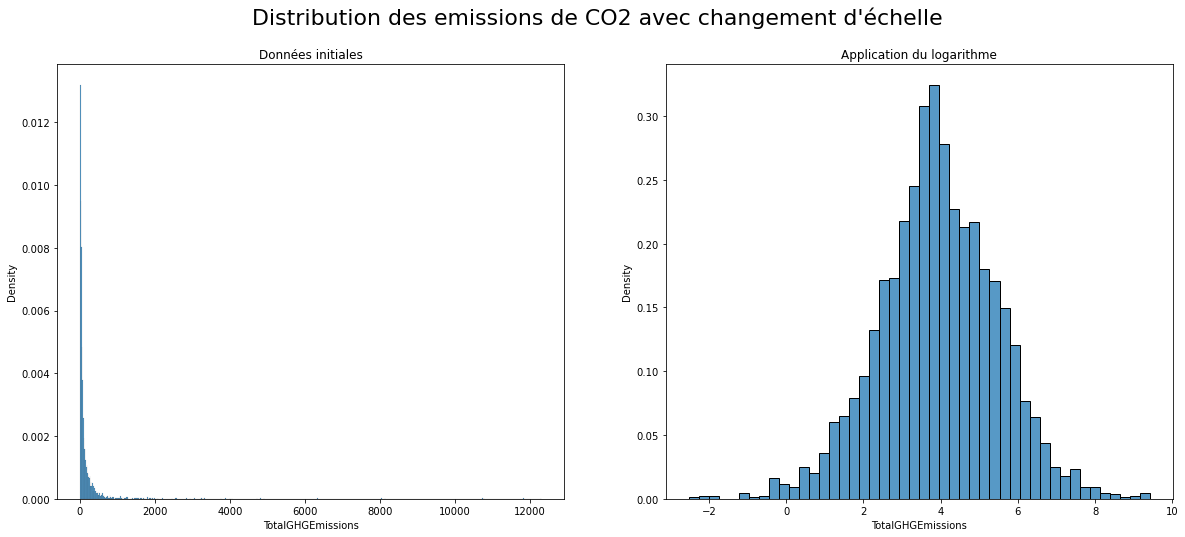

In [21]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(func= np.log, inverse_func = np.exp, check_inverse = True)
y_co2_log = log_transformer.transform(y_co2)

# Replacing infinite with nan
y_co2_log.replace([np.inf, -np.inf], np.nan, inplace=True)
  
# Dropping all the rows with nan values
y_co2_log.dropna(inplace=True)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(y_co2, stat="density", ax=axes[0])
axes[0].set_title("Données initiales")
sns.histplot(y_co2_log, stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme")
plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle",  fontsize=22)

In [24]:
model = Pipeline(steps=[(' preprocessor', preprocessor),
                           ('model', TransformedTargetRegressor(RandomForestRegressor()))])

model.fit(X_train,y_train_co2)
print("score d'entrainement = ",model.score(X_train,y_train_co2))
y_pred_co2 = model.predict(X_test)
print("score de la prédiction:")#, accuracy_score(y_test, y_pred)), 
print("MAE = ",mean_absolute_error(y_test_co2,y_pred_co2))
print("RMSE = ",np.sqrt(mean_squared_error(y_test_co2,y_pred_co2)))
print("median abs err = ",median_absolute_error(y_test_co2,y_pred_co2))

score d'entrainement =  0.9790870396043407
score de la prédiction:
MAE =  63.92200107361964
RMSE =  181.6109252627886
median abs err =  19.427399999999984


#### SiteEnergyUse

##### RandomForestRegressor

In [60]:
pipe_eng_RF = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', RandomForestRegressor())
                      ])

X_train, X_test, y_train_energy, y_test_energy = train_test_split(X,y_energy, test_size=0.2, random_state=42)

pipe_eng_RF.fit(X_train, y_train_energy)
pipe_eng_RF.score(X_test, y_test_energy)

0.906644937884495

### Feature importances

SiteEnergyUse(kBtu)

In [65]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [66]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [67]:
model = make_pipeline(preprocessor,TransformedTargetRegressor(
    regressor= GradientBoostingRegressor(n_estimators=100,random_state=None), func=np.log , inverse_func= np.exp))


In [69]:
model.fit(X_train, y_train_energy)

C:\Users\azade\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [70]:
ohe_feature_nemes= model['columntransformer'].transformers_[1][1]['OneHotEncoder'].get_feature_names()
importance = model.named_steps['transformedtargetregressor'].regressor_.feature_importances_
features_names = np.concayted([numerical_features , ohe_features_names])

KeyError: 'OneHotEncoder'

In [107]:
# zip coeff & names together and make  DataFrame
zipped = zip(features_names, importances)
df= pd.DataFrame(zipped, columns=['','importances'])

NameError: name 'features_names' is not defined

In [ ]:
# sort the features by the absolute value of their coefficient
df=df.sort_values('importance', ascending=False)